# DATA 240-21, Fall 2024
# Assignment #2

## NOTE: Please do not use any package/library including scikit-learn library except NumPy, Pandas, and Matplotlib. 

# 1. (3 pts) Implanting K-means clustering algorithm 

### Please download cluster_data1.csv. 

### K-means algorithm is a method to automatically cluster similar data examples together. K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments until they converge. 

### Let’s assume K=3. Please implement K-means clustering algorithm from scratch. Put random seed as ‘123’. Please plot the location of k centroids and their assignment for each cluster in 2D with different colors to distinguish each cluster and its centroid for the first 5 steps (the initial setting of the centroids, Then, after iteration 1/2/3/4). In your plot, set x-axis as ‘X1’ and y-axis as ‘X2’ as the below figure

In [1]:
import pandas as pd

In [2]:
df1 = pd.read_csv("cluster_data1.csv")
df1.describe()

,X1,X2,X3,X4
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [3]:
X1 = df1.values
df1.head()

,X1,X2,X3,X4
0,6.7,3.0,5.0,1.7
1,6.3,2.9,5.6,1.8
2,5.6,3.0,4.5,1.5
3,7.6,3.0,6.6,2.1
4,6.0,3.4,4.5,1.6


In [4]:
import numpy as np

"""
Distance Metrics Implementation
    1. Euclidean Distance
    2. Squared Euclidean Distance
    3. Manhattan Distance
    4. Minkowski Distance
    5. Chebyshev Distance
"""

def euclidean_distance(x1, x2):
    """Euclidean distance: sqrt(sum((x1 - x2)^2))"""
    return np.sqrt(np.sum((x1 - x2) ** 2))

def squared_euclidean_distance(x1, x2):
    """Squared Euclidean distance: sum((x1 - x2)^2)"""
    return np.sum((x1 - x2) ** 2)
    
def manhattan_distance(x1, x2):
    """Manhattan distance: sum(abs(x1 - x2))"""
    return np.sum(np.abs(x1 - x2))

def minkowski_distance(x1, x2, p=3):
    """Minkowski distance: (sum(abs(x1 - x2)^p))^(1/p)"""
    return np.sum(np.abs(x1 - x2) ** p) ** (1 / p)

def chebyshev_distance(x1, x2):
    """Chebyshev distance: max(abs(x1 - x2))"""
    return np.max(np.abs(x1 - x2))



# Helper function to compute the distance dynamically based on self.distance
def compute_distance(distance_func, x1, x2):
    if distance_func == "euclidean":
        return euclidean_distance(x1, x2)
    elif distance_func == "manhattan":
        return manhattan_distance(x1, x2)
    elif distance_func == "minkowski":
        return minkowski_distance(x1, x2, p=3)  # Default p=3, you can modify this if needed
    elif distance_func == "chebyshev":
        return chebyshev_distance(x1, x2)
    else:
        raise ValueError(f"Unknown distance function: {distance_func}")

In [5]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from collections import Counter

color_mapping = {
    0: '#1f77b4', 
    1: '#ff7f0e', 
    2: '#2ca02c'  
}

cmap = ListedColormap([color_mapping[i] for i in range(len(color_mapping))])
 
def plot_clusters(X, centroids, labels, title):
    """
    This function is used for plotting the data points and the clusters.
    """
    plt.figure(figsize=(5, 4))
    class_labels = np.unique(labels)
    num_classes = len(class_labels)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=cmap, marker='o', alpha=0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, linewidths=3)
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(num_classes)]
    handles.append(Line2D([0], [0], marker='x', color='r', markerfacecolor="red", markersize=10))
    counter = Counter(labels)
    plt.legend(handles, [f"cluster-{c}, count={counter[c]} " for c in class_labels] + ['cluster'], title='Assigned Classes', 
               loc='upper right', bbox_to_anchor=(1.5, 1))
    for idx, centroid in enumerate(centroids):
        x, y = centroid[0], centroid[1]
        plt.text(x, y, f'cluster-{idx}', fontsize=10, fontweight='bold', color='black', ha='left', va='bottom',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))
    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.grid(True)
    plt.show()
    

In [6]:
def standardize_data(X):
    """
    Standardize the dataset X. Steps
        1. Compute the mean and standard deviation of each feature.
        2. Standardize the data using the formula (X - mean) / std_dev
        
        :param X: numpy array of shape (n_samples, n_features)
        :return: standardized X, mean for the data, standard deviation for the data
    """
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    X_standardized = (X - means) / stds
    return X_standardized, means, stds


In [7]:
class KMeans:
    """
    KMeans Clustering Algorithm Implementation.
    Steps = 
        1. Initialize k centroids randomly. 
        2. Compute distances and assign clusters.
        3. Update centroids.
        4. Check for convergence.
        5. Repeat steps 2-4 until convergence or maximum iterations reached.
        6. Plot the final cluster assignment.
    """
    
    def __init__(self, k=3, n_plots=4, iteration=5, distance_func='euclidean', random_state=123, standardize=False):
        """
        Initialize the KMeans algorithm with the given parameters.
            :param k: Number of clusters (K).
            :param n_plots: Number of top plots.
            :param distance_func: Distance function to use.
            :param iteration: Maximum number of iterations.
            :param random_state: Seed for random number generator.
            :param standardize: Standardize the data.
        """
        self.k = k
        self.iteration = iteration
        self.n_plots = n_plots
        self.distance_func = distance_func
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.standardize = standardize
        self.centroids = None
        print(f"Parameters : {k = }, {iteration = }, {random_state = }, {distance_func = }, {standardize =}")
        

    def initialize_centroids(self, X):
        """
        Initialize the centroids randomly.
            :param X: input data
            :return: randomly initialized centroids
        """    
        indices = np.random.RandomState(self.random_state).choice(X.shape[0], self.k, replace=False, p=None)
        return X[indices]
            
    
    def compute_distances(self, X, centroids):
        """
        # Compute the distance between each data point and the centroids
            :param X: input features
            :param centroids: centroid for each cluster
            :return: distance between each data point and the centroids
        """
        num_points = X.shape[0]
        distances = np.zeros((num_points, self.k))
        for i in range(self.k):
            distances[:, i] = np.array([compute_distance(self.distance_func, x, centroids[i]) for x in X])
        return distances
    

    def assign_clusters(self, distances):
        """
        Assign each data point to the nearest centroid based on the distance.
            :param distances: distance between each data point and the centroids
            :return: cluster labels
        """
        return np.argmin(distances, axis=1)

    
    def update_centroids(self, X, labels):
        """
        Update the centroids based on the mean of the points assigned to each centroid. 
            :param X: input data
            :param labels: computed labels
            :return: centroid for each cluster
        """
        new_centroids = np.zeros((self.k, X.shape[1]))
        for k in range(self.k):
            new_centroids[k, :] = X[labels == k].mean(axis=0)
        return new_centroids
    
    def is_converge(self, new_centroids, current_centroids):
        """
        Check for convergence by comparing the new centroids with the current centroids.
            :param new_centroids: 
            :param current_centroids: 
            :return: true if new and current centroids are same, else false.
        """
        return np.all(new_centroids == current_centroids)

    def fit(self, X):
        """
        Fit the KMeans model to the data and return the cluster labels and centroids. 
            Steps - 
                1. Initialize centroids randomly.
                2. Compute distances and assign clusters.
                3. Update centroids.
                4. Check for convergence.
                5. Repeat steps 2-4 until convergence or maximum iterations reached.
        
            :param X: input data
            :return: cluster labels and centroids
        """
        if self.standardize:
            X, means, std = standardize_data(X) 
            
        self.centroids = self.initialize_centroids(X)
        plot_clusters(X, self.centroids, [0 for _ in range(X.shape[0])], title='Initial Centroid Assignment')
        output_labels = None
        
        for i in range(0, self.iteration+1):
            distances = self.compute_distances(X, self.centroids)
            output_labels = self.assign_clusters(distances)
            
            if i == 0:
                print("Initial cluster with the initialization randomly and there is no update to the centroids")
                plot_clusters(X, self.centroids, output_labels, title='Initial Cluster after Random Assignment')
            elif i <= self.n_plots: 
                plot_clusters(X, self.centroids, output_labels, title=f'Cluster Assignment after Iteration = {i}')

            new_centroids = self.update_centroids(X, output_labels)

            if self.is_converge(new_centroids, self.centroids):
                print(f"Converged after {i} iterations.")
                break

            self.centroids = new_centroids

        plot_clusters(X, self.centroids, output_labels,  title=f'Final Cluster Assignment after Iteration = {i}')
        return output_labels, self.centroids


Parameters : k = 3, iteration = 20, random_state = 123, distance_func = 'euclidean', standardize =False


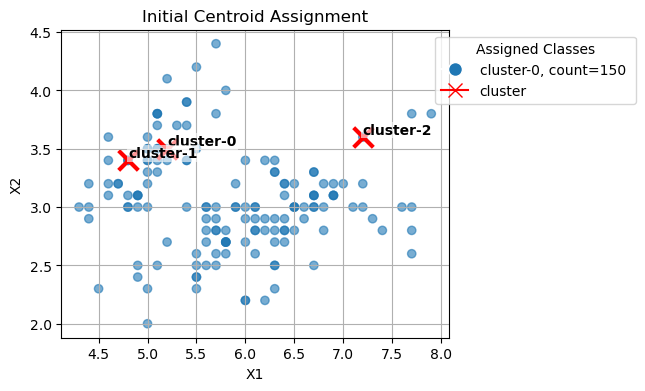

Initial cluster with the initialization randomly and there is no update to the centroids


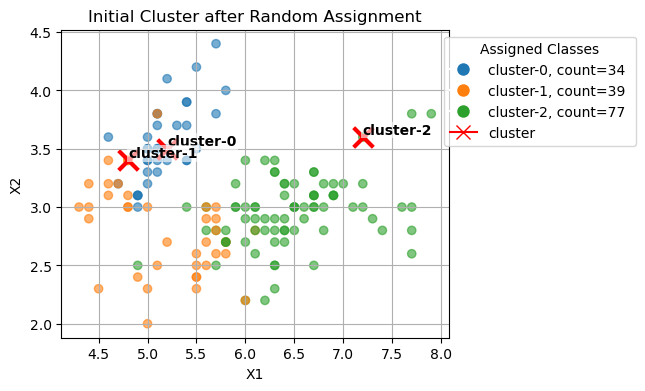

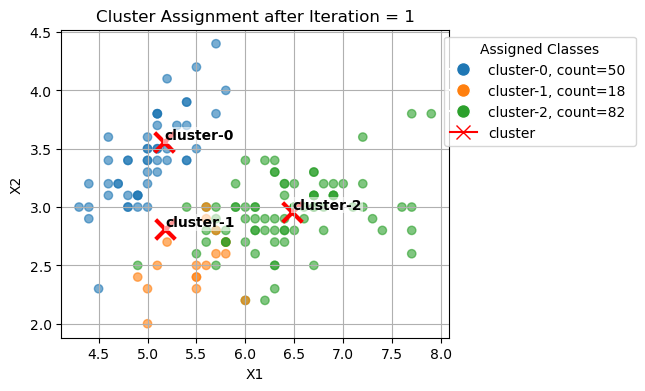

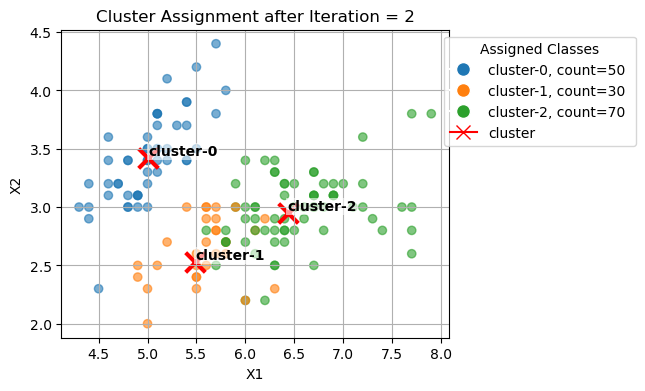

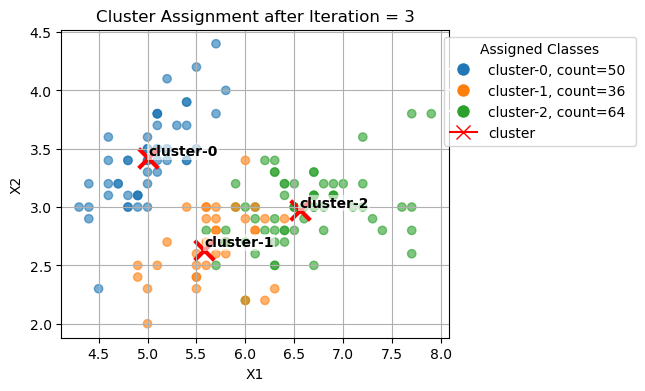

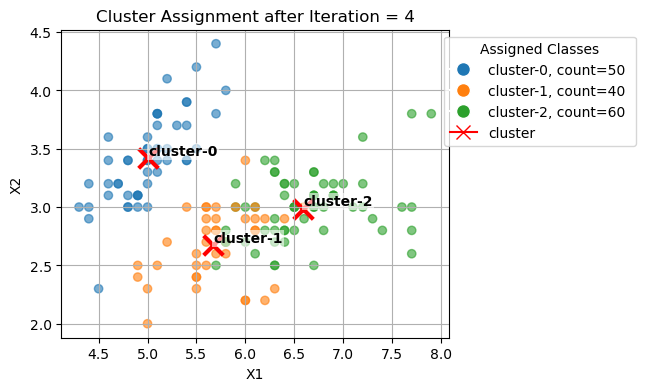

Converged after 11 iterations.


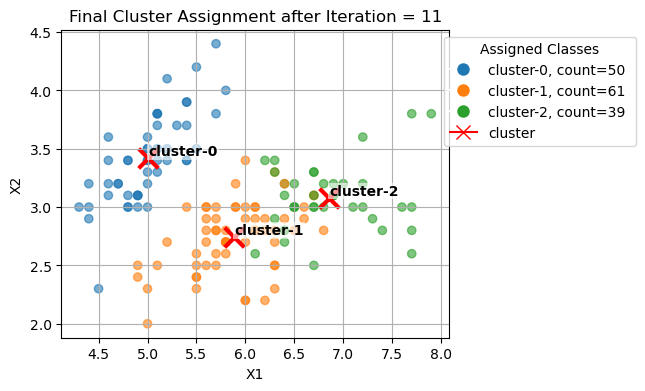

Counter({1: 61, 0: 50, 2: 39})
[[5.006      3.418      1.464      0.244     ]
 [5.88360656 2.74098361 4.38852459 1.43442623]
 [6.85384615 3.07692308 5.71538462 2.05384615]]


In [8]:
kmeans = KMeans(k=3, n_plots=4, iteration=20, random_state=123, standardize=False)
k_means_labels, k_means_centroids = kmeans.fit(X1)

from collections import Counter
print(Counter(k_means_labels))
print(k_means_centroids)

Parameters : k = 3, iteration = 20, random_state = 123, distance_func = 'euclidean', standardize =True


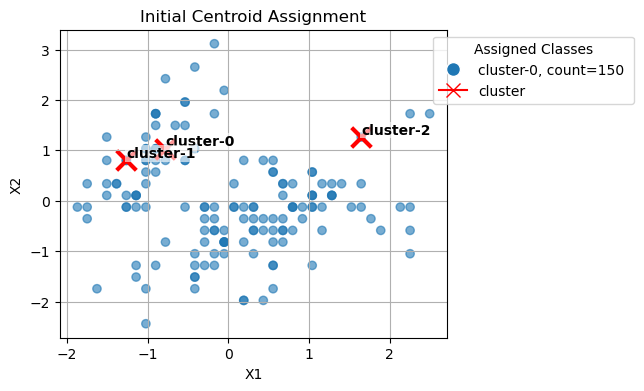

Initial cluster with the initialization randomly and there is no update to the centroids


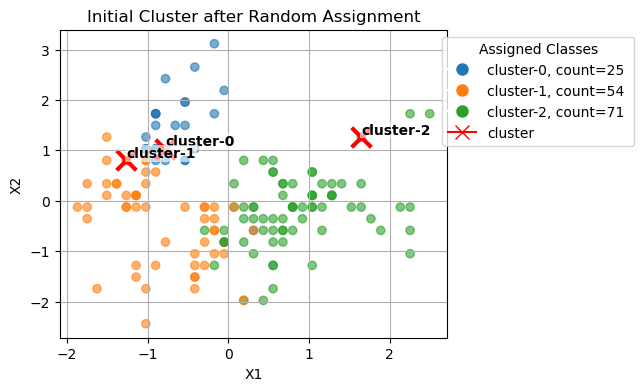

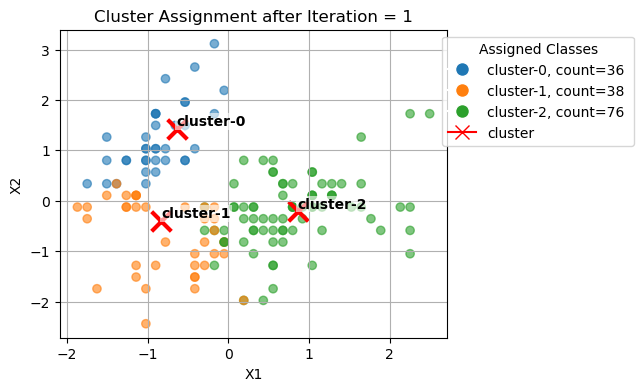

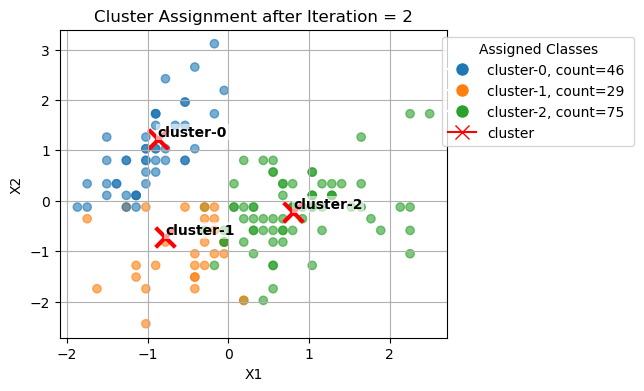

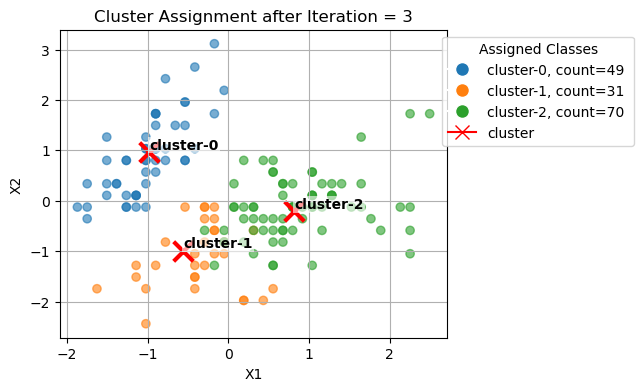

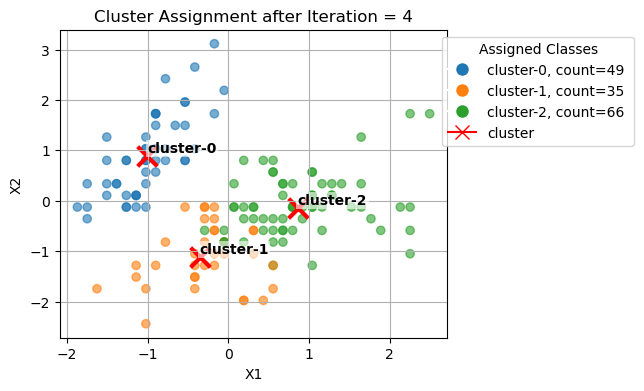

Converged after 8 iterations.


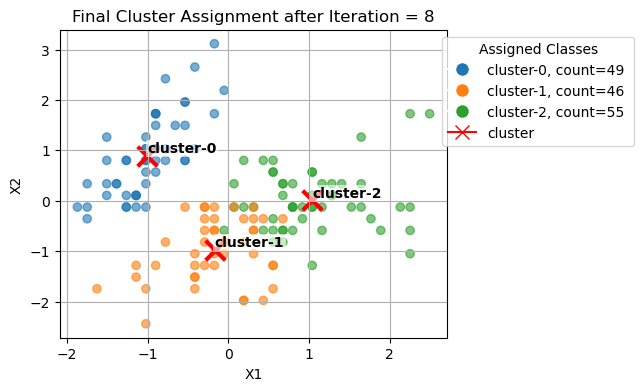

Counter({2: 55, 0: 49, 1: 46})
[[-1.00206653  0.89510445 -1.30297509 -1.25663117]
 [-0.16840578 -0.97008147  0.25962078  0.17609756]
 [ 1.03359865  0.01388418  0.94369497  0.97226253]]


In [9]:
kmeans_std = KMeans(k=3, n_plots=4, iteration=20, random_state=123, standardize=True)
k_means_labels_std, k_means_centroids_std = kmeans_std.fit(X1)

print(Counter(k_means_labels_std))
print(k_means_centroids_std)

### Observations -

- The K-Means algorithm converges in 11 iterations.
- The initial cluster assignment is not well distributed where the initial two clusters are very close to each other.
- The final cluster assignment is well distributed and the centroids are well-placed.
- In the plot we can some overlap, because we are using just 2 features to cluster the data.
- We can also see that how feature standardization can affect the clustering results.

### Effect of feature Standardization - 
- Standardizing the data can help in better convergence and faster clustering.
- The final cluster assignment is well distributed and the centroids are well-placed that can be seen from the data distribution in different clusters.


# 2. (3 pts) Implanting K-means++ clustering algorithm and finding K 

### The converged solution may not always be ideal and depends on the initial setting of the centroids. To address this issue, K-means++ was introduced. You should implement K-means++ algorithm as described during the class.

### Please implement K-means++ algorithm from scratch. Put random seed as ‘123’. Please plot the location of k centroids and their assignment for each cluster in 2D with different colors to distinguish each cluster and its centroid for the first 5 steps (the initial setting of the centroids, Then, after iteration 1/2/3/4). In your plot, set x-axis as ‘X1’ and y-axis as ‘X2’ as the above figure.

In [10]:
import pandas as pd

class KMeansPlusPlus:
    """
    KMeans++ Clustering Algorithm Implementation.
    Steps = 
        1. Initialize centroids using K-means++ method (instead of random initialization). 
            a. The first cluster is chosen uniformly at random from the data points. This is similar to K-Means, 
                but instead of randomly picking all the centroids, we just pick one centroid here.
            b. Next, we compute the distance of each data point from the centroid.
            c. Then, choose the next centroid from the data points with the longest distance from the previous centroids.
            d. We then repeat steps 2 and 3 until k centroids have been chosen.
            
        2. Compute distances and assign clusters.
        3. Update centroids.
        4. Check for convergence.
        5. Repeat steps 2-4 until convergence or maximum iterations reached.
        6. Plot the final cluster assignment.
    """
    
    def __init__(self, k=3, n_plots=4, iteration=5, distance_func='euclidean', random_state=123, standardize=False):
        """
        Initialize the KMeans++ algorithm with the given parameters.
            :param k: Number of clusters (K).
            :param n_plots: Number of top plots.
            :param iteration: Maximum number of iterations.
            :param distance_func: Distance function to use.
            :param random_state: Seed for random number generator.
            :param standardize: Standardize the data.
        """
        
        self.k = k
        self.iteration = iteration
        self.n_plots = n_plots
        self.distance_func = distance_func
        self.centroids = None
        self.standardize = standardize
        self.random_state = random_state
        np.random.seed(self.random_state)
        print(f"Parameters : {k = }, {iteration = }, {random_state = }, {distance_func = }, {standardize =}")

        
    def initialize_centroids(self, X):
        """
            Initialize the centroids using K-means++ method (instead of random initialization).
            Steps - 
                a. The first cluster is chosen uniformly at random from the data points. This is similar to K-Means, 
                   but instead of randomly picking all the centroids, we just pick one centroid here.
                b. Next, we compute the distance of each data point from the centroid.
                c. Then, choose the next centroid from the data points with the longest distance from the previous centroids.
                d. We then repeat steps 2 and 3 until k centroids have been chosen.
        
            :param X: input data 
            :return: initial centroids
        """
        idx = np.random.RandomState(self.random_state).choice(X.shape[0])
        centroids = [X[idx]]
    
        for i in range(1, self.k):
            distances = np.array([min(np.linalg.norm(x - c)**2 for c in centroids) for x in X])
            idx = np.argmax(distances)
            centroids.append(X[idx])

        return np.array(centroids)
     

    def compute_distances(self, X, centroids):
        """
        Compute the distance between each data point and the centroids.
            :param X: input features
            :param centroids: centroid for each cluster
            :return:  distance between each data point and the centroids
        """
        num_points = X.shape[0]
        distances = np.zeros((num_points, self.k))
        for i in range(self.k):
            distances[:, i] = np.array([compute_distance(self.distance_func, x, centroids[i]) for x in X])
        return distances

    def assign_clusters(self, distances):
        """
        Assign each data point to the nearest centroid based on the distance.
            :param distances: distance between each data point and the centroids 
            :return: cluster labels
        """
        return np.argmin(distances, axis=1)

    def update_centroids(self, X, labels):
        """
        Update the centroids based on the mean of the points assigned to each centroid.
            :param X: input data
            :param labels: computed labels
            :return: centroid for each cluster
        """
        centroids = np.zeros((self.k, X.shape[1]))
        for k in range(self.k):
            centroids[k, :] = X[labels == k].mean(axis=0)
        return centroids

    def is_converge(self, new_centroids, current_centroids):
        """
        Check for convergence by comparing the new centroids with the current centroids.
            :param new_centroids: 
            :param current_centroids: 
            :return: true if new and current centroids are same, else false.
        """
        return np.all(new_centroids == current_centroids)
    
    def fit(self, X):
        """
        Fit the KMeans++ model to the data and return the cluster labels and centroids.
            Steps - 
                1. Initialize centroids using K-means++ method.
                2. Compute distances and assign clusters.
                3. Update centroids.
                4. Check for convergence.
                5. Repeat steps 2-4 until convergence or maximum iterations reached.
                
            :param X: input data 
            :return: cluster labels and centroids
        """
        if self.standardize:
            X, means, std = standardize_data(X)
            
        self.centroids = self.initialize_centroids(X)
        output_labels = None
        plot_clusters(X, self.centroids, [0 for _ in range(X.shape[0])], title='Initial Centroid Assignment with K-Means++')

        for i in range(0, self.iteration + 1):
            distances = self.compute_distances(X, self.centroids)
            output_labels = self.assign_clusters(distances)

            if i == 0:
                plot_clusters(X, self.centroids, output_labels, title='Initial Cluster Assignment with K-Means++')
            elif i <= self.n_plots: 
                plot_clusters(X, self.centroids, output_labels, title=f'Cluster Assignment after Iteration = {i}')
            
            new_centroids = self.update_centroids(X, output_labels)

            if self.is_converge(new_centroids, self.centroids) and i>=self.n_plots:
                print(f"Converged after {i} iterations.")
                break

            self.centroids = new_centroids

        plot_clusters(X, self.centroids, output_labels, title=f'Final Cluster Assignment after Iteration = {i}')
        return output_labels, self.centroids


Parameters : k = 3, iteration = 15, random_state = 123, distance_func = 'euclidean', standardize =False


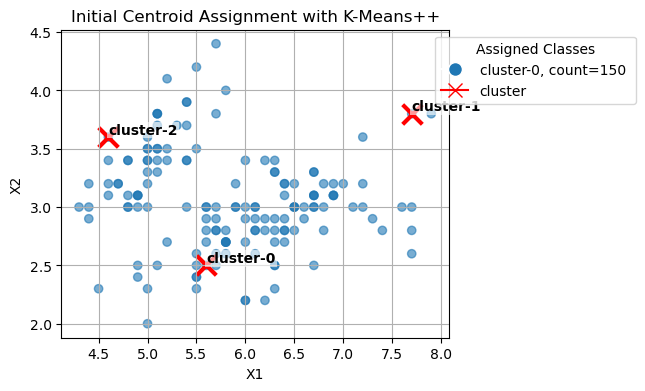

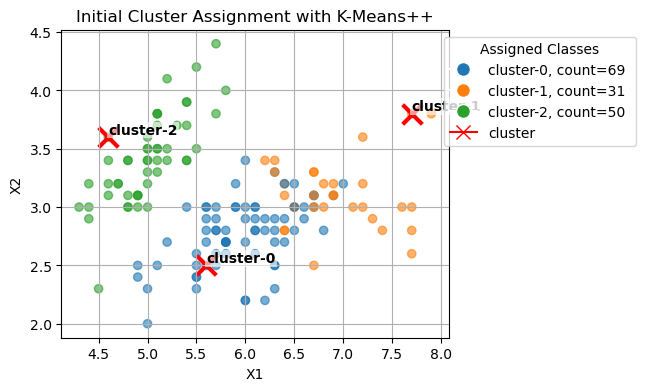

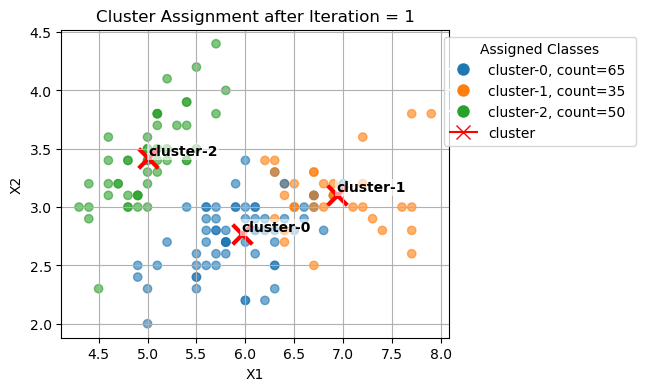

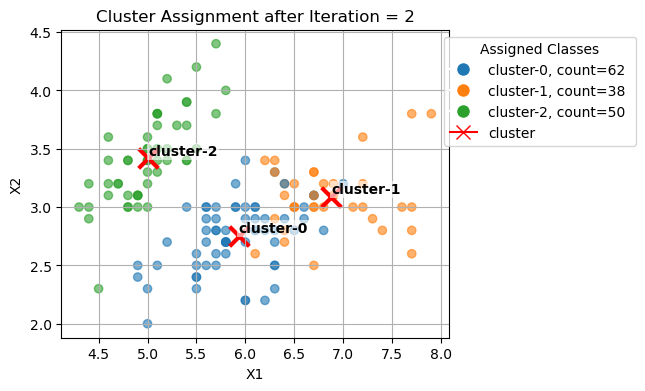

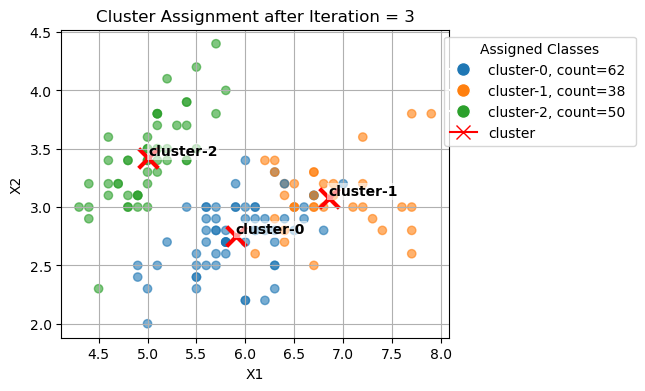

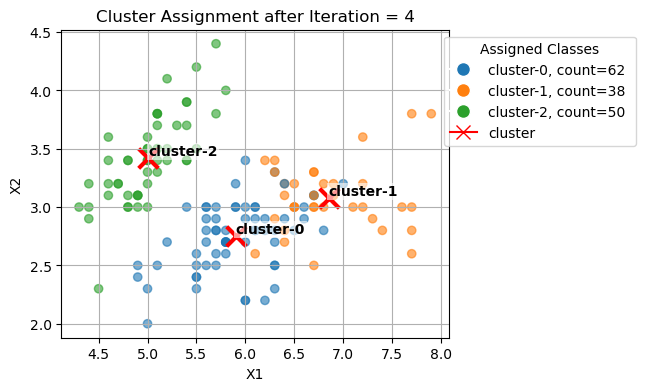

Converged after 4 iterations.


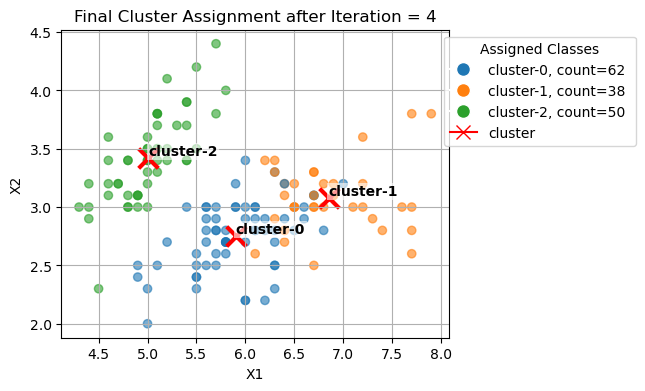

Counter({0: 62, 2: 50, 1: 38})
[[5.9016129  2.7483871  4.39354839 1.43387097]
 [6.85       3.07368421 5.74210526 2.07105263]
 [5.006      3.418      1.464      0.244     ]]


In [11]:
kmeans_plus_plus = KMeansPlusPlus(k=3, iteration=15)
kmeans_plus_plus_labels, kmeans_plus_plus_centroids = kmeans_plus_plus.fit(X1)

print(Counter(kmeans_plus_plus_labels))
print(kmeans_plus_plus_centroids)

Parameters : k = 3, iteration = 15, random_state = 123, distance_func = 'euclidean', standardize =True


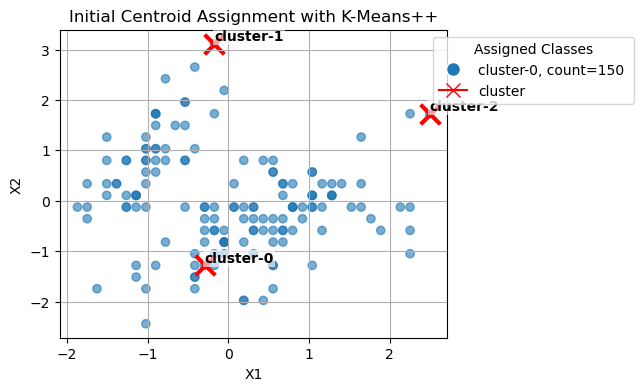

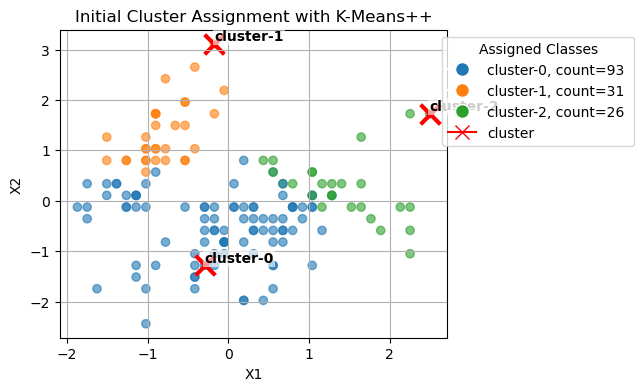

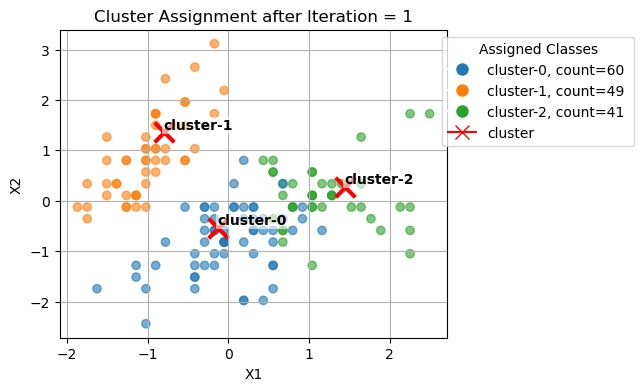

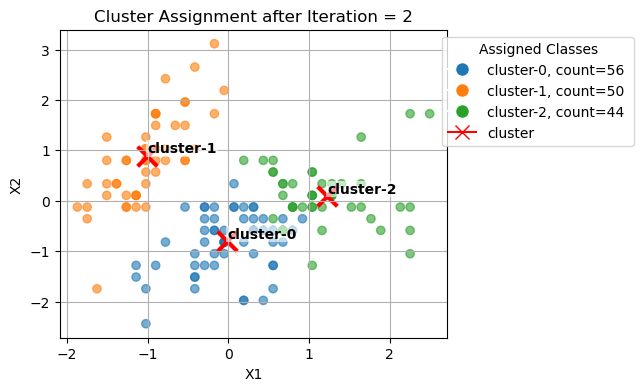

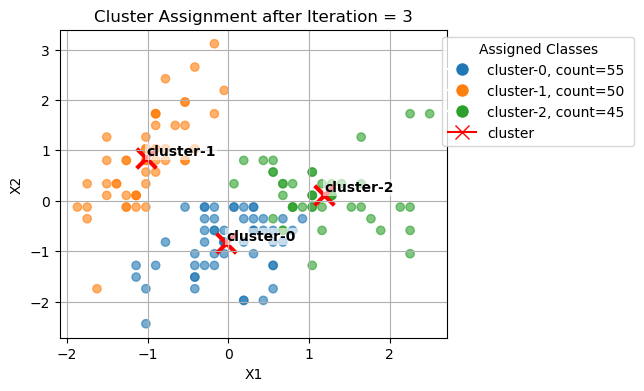

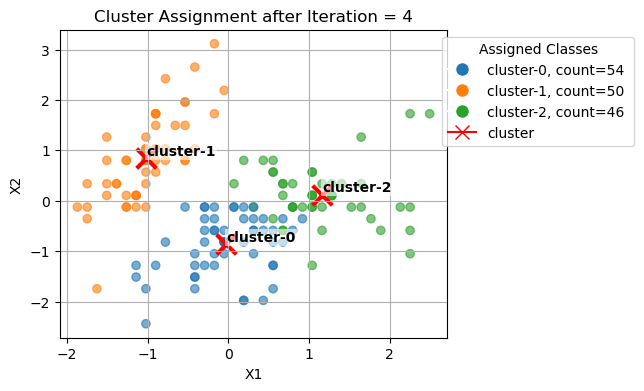

Converged after 6 iterations.


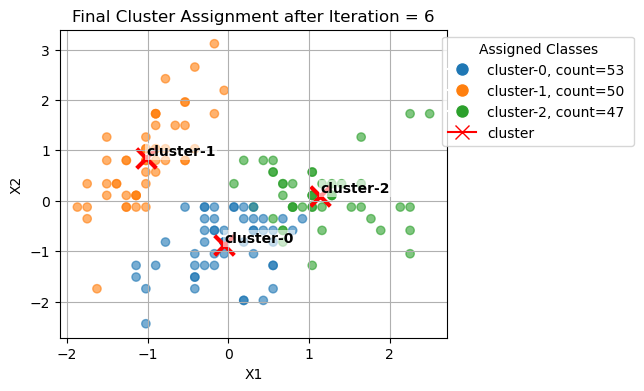

Counter({0: 53, 1: 50, 2: 47})
[[-0.05021989 -0.88029181  0.34753171  0.28206327]
 [-1.01457897  0.84230679 -1.30487835 -1.25512862]
 [ 1.13597027  0.09659843  0.996271    1.01717187]]


In [12]:
"""
Trying the same algorithm with the 
"""
kmeans_plus_plus_std = KMeansPlusPlus(k=3, iteration=15, standardize=True)
kmeans_plus_plus_labels_std, kmeans_plus_plus_centroids_std = kmeans_plus_plus_std.fit(X1)

print(Counter(kmeans_plus_plus_labels_std))
print(kmeans_plus_plus_centroids_std)

### Observations - 

- K-Means++ initial cluster assignment is much better and well distributed where K-Means cluster initialization is randon and the initials two cluster are very close to each other.
- As we can see this K-Means++ algorithm converges faster than the K-Means algorithm.
- The K-Means algorithm converges in 11 iterations but K-Means++ algorithm converges in 5 iterations.
- The final cluster assignment is well distributed and the centroids are well-placed.
- In the plot we can some overlap, because we are using just 2 features to plot the data.
- We can also see that how feature standardization can affect the clustering results.
- Standardizing the data can help in better convergence and faster clustering.
- The final cluster assignment is well distributed and the centroids are well-placed that can be seen from the data distribution in different clusters. 


# 3. (4 pts) Implanting KNN classification 

### Please download cluster_data2.csv. 

### Please implement KNN classification algorithm from scratch. Please assign class for each data point based on the result of problem #2 using K-NN method.

In [13]:
df_test = pd.read_csv("cluster_data2.csv")
df_test.describe()

,X1,X2,X3,X4
count,15.000000,15.000000,15.000000,15.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.691165,0.295074,1.771032,0.761923
min,4.860000,2.650000,1.420000,0.190000
25%,5.140000,2.860000,1.510000,0.280000
50%,5.850000,2.960000,4.270000,1.340000
75%,6.500000,3.320000,5.415000,1.935000
max,6.740000,3.650000,5.770000,2.170000


In [14]:
class KNN:
    """
    K-Nearest Neighbors Classification Algorithm Implementation.
    Steps =
        1. Compute the distance between each data point and the centroids.
        2. Assign the class based on the majority class of the K-nearest neighbors.
        3. Plot the final classified points.    
    """  
    
    def __init__(self, k=3, distance_func="euclidean"):
        """
        Initialize the KNN algorithm with the given parameters.
            :param k: Number of nearest neighbors.
            :param distance_func: Distance function to use.
        """
        self.k = k
        self.distance_func = distance_func
        self.X_train = None
        self.y_train = None

    
    def fit(self, X_train, y_train):
        """
        Fit the KNN model to the training data.
            :param X_train: sample inputs 
            :param y_train:  corresponding labels
            :return: 
        """
        self.X_train = X_train
        self.y_train = y_train

    def get_distance(self, x1, x2):
        """ Find distance between two points"""
        return compute_distance(self.distance_func, x1, x2)

    
    def get_k_neighbours(self, x):
        """
        Find the K-nearest neighbors for a single data point.
            :param x: input data point
            :return: K-nearest neighbors
        """
        distances = [self.get_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return k_nearest_labels

    
    def _predict(self, x):
        """
        assign the class for a single data point. Steps - 
            1. Compute the distance between each data point and the centroids.
            2. Identify the K-nearest neighbors based on these distances.
            3. Assign the class based on the majority class of the K-nearest neighbors.
            
            :param x: input data point 
            :return: nearest class
        """
        k_nearest_labels = self.get_k_neighbours(x)
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    
    def predict(self, X_test):
        """
        assign the class for a list of data point.  
            :param X_test: input data points
            :return: predicted classes
        """
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)
            
    
    def plot(self, X, y, title="KNN Classification"):
        """
        Plot the final classified points.
            :param X: input features
            :param y: predicted classes
            :param title: title of the plot
            :return: 
        """
        plt.figure(figsize=(5, 4))
        class_labels = np.unique(y)
        num_classes = len(class_labels)
        
        scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, marker='o', alpha=0.6)
        handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(num_classes)]        
        counter = Counter(y)
        plt.legend(handles, [f"cluster-{c}, count={counter[c]}" for c in class_labels], title='Predicted Classes', loc='upper right')
        plt.title(title)
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.grid(True) 
        plt.show()

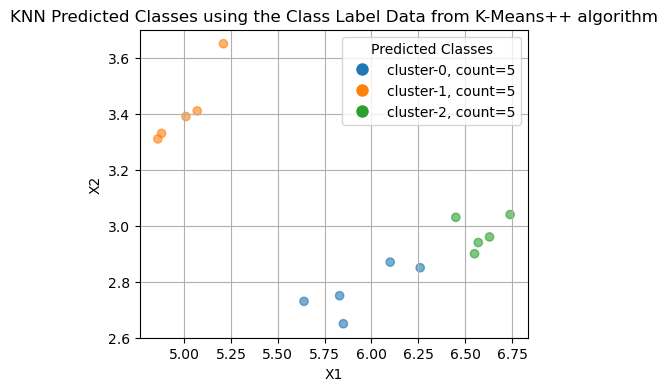

,X1,X2,X3,X4,KNN_Predicted_Class
0,5.21,3.65,1.42,0.25,1
1,5.07,3.41,1.43,0.19,1
2,5.85,2.65,4.14,1.27,0
3,5.64,2.73,4.03,1.23,0
4,6.55,2.90,5.54,2.05,2


In [15]:
"""
Using KNN algorithm to get the predicted classes
"""

knn = KNN(k=3)
knn.fit(X1, kmeans_plus_plus_labels_std)

X_test = df_test.values
knn_predictions = knn.predict(X_test)

df_test_output = df_test.copy()
df_test_output['KNN_Predicted_Class'] = knn_predictions
knn.plot(X_test, knn_predictions, title="KNN Predicted Classes using the Class Label Data from K-Means++ algorithm")
df_test_output.head()

### Observations -

 - The KNN classifier is able to classify the data points based on the cluster labels obtained from K-Means++ algorithm.
 - The plot shows the classified points along with their true classes.
 - The KNN classifier is able to classify the data points with high accuracy.
